Poisson's equation:

$\Delta \phi = \rho$

In 2d in Cartesian coords:

$\dfrac{ \partial^2 \phi }{ \partial x^2 } + \dfrac{ \partial^2 \phi }{ \partial y^2 } = \rho$



Suppose:

$ \phi = x^2 + y^3 $

then

$ \rho = 2 + 6 y $

In [2]:
def exact(x, y):
    return( x * x + y * y * y )


def exact_rhs(x, y):
    return( 2 + 6 * y )

Discretizing the equation using finite difference method
with [central difference](https://en.wikipedia.org/wiki/Finite_difference) for 2nd order derivative:

$\dfrac{ \phi_{i-1,j} - 2 \phi_{i,j} + \phi_{i+1,j} }{ \Delta x^2 } + 
 \dfrac{ \phi_{i,j-1} - 2 \phi_{i,j} + \phi_{i,j+1} }{ \Delta y^2 } = \rho$


Simple approach:

$\Delta y^2 ( \phi_{i-1,j} - 2 \phi_{i,j} + \phi_{i+1,j} ) + 
 \Delta x^2 ( \phi_{i,j-1} - 2 \phi_{i,j} + \phi_{i,j+1} ) = \rho \Delta x^2 \Delta y^2$

$ \phi_{i,j} = 
\dfrac{ \Delta y^2( \phi_{i-1,j} + \phi_{i+1,j} ) + 
        \Delta x^2( \phi_{i,j+1} + \phi_{i,j-1} ) - \rho \Delta x^2 \Delta y^2 }{2 (\Delta x^2 + \Delta y^2) }$
        
Iterative solution:

In [3]:
import numpy as np


def solve_Jacobi_no_matrix( rho, guess, norm_abs_tol=1e-6, maxiter=100 ):
    prev_phi = guess        
    for k in range( maxiter ):
        updated_phi = single_Jacobi_no_matrix_iteration( rho, prev_phi ) # todo: accept next_phi
        print( "iteration", k )
        print( updated_phi )
        if is_converged( prev_phi, updated_phi, norm_abs_tol ):
            return updated_phi
        prev_phi = updated_phi
    print( "Warning: didn't converge after maxiter" )
    return updated_phi

def single_Jacobi_no_matrix_iteration( rho, prev_phi ):
    dxdx = dx * dx
    dydy = dy * dy
    dxdxdydy = dxdx * dydy
    two_times_dxdx_plus_dydy = 2 * (dxdx + dydy)
    updated_phi = np.empty_like( prev_phi )
    for i in range(nx):
        updated_phi[i][0] = prev_phi[i][0]
        updated_phi[i][ny-1] = prev_phi[i][ny-1]
    for j in range(ny):
        updated_phi[0][j] = prev_phi[0][j]
        updated_phi[nx-1][j] = prev_phi[nx-1][j]
    for i in range(1, nx - 1):
        for j in range(1, ny - 1):
            updated_phi[i][j] = (prev_phi[i-1][j] + prev_phi[i+1][j]) * dydy
            updated_phi[i][j] = updated_phi[i][j] + (prev_phi[i][j-1] + prev_phi[i][j+1]) * dxdx
            updated_phi[i][j] = updated_phi[i][j] - rho[i][j] * dxdxdydy
            updated_phi[i][j] = updated_phi[i][j] / two_times_dxdx_plus_dydy
    return updated_phi


def is_converged( prev_phi, updated_phi, norm_abs_tol ):
    return np.sqrt( np.linalg.norm( updated_phi - prev_phi ) ) < norm_abs_tol


Select mesh:

In [4]:
nx = 8
ny = 8
dx = 0.1
dy = 0.3
x0 = 0
y0 = 0

Define exact and approx solutions:

In [5]:
exact_sol = np.empty( [nx, ny] )
approx_sol = np.empty_like( exact_sol )
rhs = np.empty_like( exact_sol )

def set_exact_solution( exact_sol ):
    for i in range( nx ):
        for j in range( ny ):
            x = x0 + i * dx
            y = y0 + j * dy
            exact_sol[i][j] = exact( x, y )
    return exact_sol

def set_rhs( rhs ):
    rhs.fill( np.nan )
    for i in range( 1, nx-1 ):
        for j in range( 1, ny-1 ):
            x = x0 + i * dx
            y = y0 + j * dy
            rhs[i][j] = exact_rhs( x, y )
    return rhs

def set_boundary_cond_in_approx_sol( approx_sol ):
    approx_sol.fill( 0 )
    for i in range( nx ):
        x = x0 + i * dx
        approx_sol[i][0] = exact( x, y0 + 0 * dy )
        approx_sol[i][ny-1] = exact( x, y0 + (ny-1) * dy )
    for j in range( ny ):
        y = y0 + j * dy
        approx_sol[0][j] = exact( x0 + 0 * dx, y )
        approx_sol[nx-1][j] = exact( x0 + (nx-1) * dx, y )
    return approx_sol



exact_sol = set_exact_solution( exact_sol )
rhs = set_rhs( rhs )
approx_sol = set_boundary_cond_in_approx_sol( approx_sol )

print( exact_sol )
print( approx_sol )


[[ 0.     0.027  0.216  0.729  1.728  3.375  5.832  9.261]
 [ 0.01   0.037  0.226  0.739  1.738  3.385  5.842  9.271]
 [ 0.04   0.067  0.256  0.769  1.768  3.415  5.872  9.301]
 [ 0.09   0.117  0.306  0.819  1.818  3.465  5.922  9.351]
 [ 0.16   0.187  0.376  0.889  1.888  3.535  5.992  9.421]
 [ 0.25   0.277  0.466  0.979  1.978  3.625  6.082  9.511]
 [ 0.36   0.387  0.576  1.089  2.088  3.735  6.192  9.621]
 [ 0.49   0.517  0.706  1.219  2.218  3.865  6.322  9.751]]
[[ 0.     0.027  0.216  0.729  1.728  3.375  5.832  9.261]
 [ 0.01   0.     0.     0.     0.     0.     0.     9.271]
 [ 0.04   0.     0.     0.     0.     0.     0.     9.301]
 [ 0.09   0.     0.     0.     0.     0.     0.     9.351]
 [ 0.16   0.     0.     0.     0.     0.     0.     9.421]
 [ 0.25   0.     0.     0.     0.     0.     0.     9.511]
 [ 0.36   0.     0.     0.     0.     0.     0.     9.621]
 [ 0.49   0.517  0.706  1.219  2.218  3.865  6.322  9.751]]


Solve:

In [6]:
guess = approx_sol
abs_tol = np.max([dx**2, dy**2]) / 10
print( guess )
approx_sol = solve_Jacobi_no_matrix( rhs, guess, norm_abs_tol=abs_tol, maxiter=100 )

[[ 0.     0.027  0.216  0.729  1.728  3.375  5.832  9.261]
 [ 0.01   0.     0.     0.     0.     0.     0.     9.271]
 [ 0.04   0.     0.     0.     0.     0.     0.     9.301]
 [ 0.09   0.     0.     0.     0.     0.     0.     9.351]
 [ 0.16   0.     0.     0.     0.     0.     0.     9.421]
 [ 0.25   0.     0.     0.     0.     0.     0.     9.511]
 [ 0.36   0.     0.     0.     0.     0.     0.     9.621]
 [ 0.49   0.517  0.706  1.219  2.218  3.865  6.322  9.751]]
iteration 0
[[  0.00000000e+00   2.70000000e-02   2.16000000e-01   7.29000000e-01
    1.72800000e+00   3.37500000e+00   5.83200000e+00   9.26100000e+00]
 [  1.00000000e-02  -4.45000000e-03   7.20000000e-02   2.94750000e-01
    7.36200000e-01   1.46925000e+00   3.03035000e+00   9.27100000e+00]
 [  4.00000000e-02  -1.51000000e-02  -2.52000000e-02  -3.33000000e-02
   -4.14000000e-02  -4.95000000e-02   4.07450000e-01   9.30100000e+00]
 [  9.00000000e-02  -1.26000000e-02  -2.52000000e-02  -3.33000000e-02
   -4.14000000e-02  -4

iteration 57
[[ 0.          0.027       0.216       0.729       1.728       3.375       5.832
   9.261     ]
 [ 0.01        0.03602389  0.22405903  0.7362328   1.73481649  3.3821221
   5.84027103  9.271     ]
 [ 0.04        0.06524007  0.25250377  0.76401311  1.76226295  3.40981549
   5.86888346  9.301     ]
 [ 0.09        0.1148067   0.30163867  0.81278216  1.81084673  3.45853342
   5.91811504  9.351     ]
 [ 0.16        0.1848054   0.37164028  0.88278145  1.88084602  3.52853502
   5.98811374  9.421     ]
 [ 0.25        0.27524111  0.46250249  0.97401368  1.97226352  3.61981421
   6.07888451  9.511     ]
 [ 0.36        0.38602331  0.57405974  1.08623248  2.08481618  3.73212281
   6.19027045  9.621     ]
 [ 0.49        0.517       0.706       1.219       2.218       3.865       6.322
   9.751     ]]
iteration 58
[[ 0.          0.027       0.216       0.729       1.728       3.375       5.832
   9.261     ]
 [ 0.01        0.03611098  0.22423953  0.73649968  1.73513607  3.38242135
   5.8

Compare exact and approx:

In [7]:



def compare_appr_and_exact( phi_exact, phi_appr ):
    for i in range( nx ):
        for j in range( ny ):
            abs_diff = (phi_exact[i][j] - phi_appr[i][j]) 
            rel_diff = (phi_exact[i][j] - phi_appr[i][j]) / phi_exact[i][j] 
            print( i,j, "|", phi_exact[i][j], phi_appr[i][j], "|", abs_diff, rel_diff )

compare_appr_and_exact( exact_sol, approx_sol )

0 0 | 0.0 0.0 | 0.0 nan
0 1 | 0.027 0.027 | 0.0 0.0
0 2 | 0.216 0.216 | 0.0 0.0
0 3 | 0.729 0.729 | 0.0 0.0
0 4 | 1.728 1.728 | 0.0 0.0
0 5 | 3.375 3.375 | 0.0 0.0
0 6 | 5.832 5.832 | 0.0 0.0
0 7 | 9.261 9.261 | 0.0 0.0
1 0 | 0.01 0.01 | 0.0 0.0
1 1 | 0.037 0.0369652843452 | 3.47156547721e-05 0.000938260939787
1 2 | 0.226 0.225935415616 | 6.45843843912e-05 0.000285771612351
1 3 | 0.739 0.738915784769 | 8.42152314827e-05 0.000113958364659
1 4 | 1.738 1.73791163019 | 8.83698123786e-05 5.08456918174e-05
1 5 | 3.385 3.38492607989 | 7.39201108519e-05 2.18375512118e-05
1 6 | 5.842 5.84195779721 | 4.22027941429e-05 7.22403186287e-06
1 7 | 9.271 9.271 | 0.0 0.0
2 0 | 0.04 0.04 | 0.0 0.0
2 1 | 0.067 0.0669374342504 | 6.25657496059e-05 0.000933817158297
2 2 | 0.256 0.255883635801 | 0.000116364198732 0.000454547651298
2 3 | 0.769 0.768848243684 | 0.000151756316454 0.000197342414115
2 4 | 1.768 1.76784075739 | 0.000159242612547 9.00693509878e-05
2 5 | 3.415 3.4148668134 | 0.000133186596532 3.90004

/home/noway/progs/python/jupyter_venv/local/lib/python3.4/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in double_scalars
  


## Red-Black Gauss-Seidel without Matrix

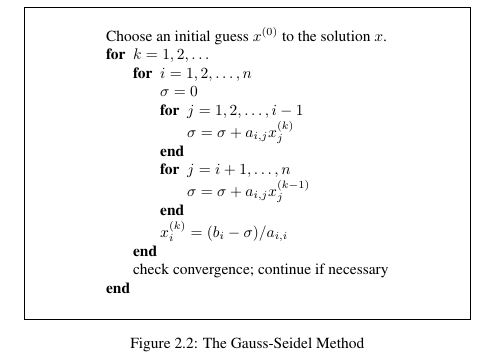

Simple approach:

$\Delta y^2 ( \phi_{i-1,j} - 2 \phi_{i,j} + \phi_{i+1,j} ) + 
 \Delta x^2 ( \phi_{i,j-1} - 2 \phi_{i,j} + \phi_{i,j+1} ) = \rho \Delta x^2 \Delta y^2$

$ \phi_{i,j} = 
\dfrac{ \Delta y^2( \phi_{i-1,j} + \phi_{i+1,j} ) + 
        \Delta x^2( \phi_{i,j+1} + \phi_{i,j-1} ) - \rho \Delta x^2 \Delta y^2 }{2 (\Delta x^2 + \Delta y^2) }$

Coloring:

* odd j, odd i : red  
* odd j, even i : black
* even j, odd i : black  
* even j, even i : red  

Red:

$ \phi_{red\,i,j}^{n+1} = 
\dfrac{ \Delta y^2( \phi_{i-1,j}^n + \phi_{i+1,j}^n ) + 
        \Delta x^2( \phi_{i,j+1}^n + \phi_{i,j-1}^n ) - \rho \Delta x^2 \Delta y^2 }{2 (\Delta x^2 + \Delta y^2) }$
  

Black:

$ \phi_{black\,i,j}^{n+1} = 
\dfrac{ \Delta y^2( \phi_{i-1,j}^{n+1} + \phi_{i+1,j}^{n+1} ) + 
        \Delta x^2( \phi_{i,j+1}^{n+1} + \phi_{i,j-1}^{n+1} ) - \rho \Delta x^2 \Delta y^2 }
        {2 (\Delta x^2 + \Delta y^2) }$

Iterative solution:

In [8]:
def solve_GaussSeidel_no_matrix( rho, guess, norm_abs_tol=1e-6, maxiter=100 ):
    prev_phi = guess        
    for k in range( maxiter ):
        updated_phi = single_GaussSeidel_no_matrix_iteration( rho, prev_phi ) # todo: accept next_phi
        print( "iteration", k )
        print( updated_phi )
        if is_converged( prev_phi, updated_phi, norm_abs_tol ):
            return updated_phi
        prev_phi = updated_phi
    print( "Warning: didn't converge after maxiter" )
    return updated_phi

# todo: do not use prev_phi;
# problem without prev_phi: how to check convergence?
def single_GaussSeidel_no_matrix_iteration( rho, prev_phi ):
    dxdx = dx * dx
    dydy = dy * dy
    dxdxdydy = dxdx * dydy
    two_times_dxdx_plus_dydy = 2 * (dxdx + dydy)
    x_step = 2
    updated_phi = np.empty_like( prev_phi )
    for i in range(nx):
        updated_phi[i][0] = prev_phi[i][0]
        updated_phi[i][ny-1] = prev_phi[i][ny-1]
    for j in range(ny):
        updated_phi[0][j] = prev_phi[0][j]
        updated_phi[nx-1][j] = prev_phi[nx-1][j]
    # red
    for j in range(1, ny - 1):        
        if odd( j ):
            x_start = 1
            for i in range(x_start, nx - 1, x_step):
                updated_phi[i][j] = (prev_phi[i-1][j] + prev_phi[i+1][j]) * dydy
                updated_phi[i][j] = updated_phi[i][j] + (prev_phi[i][j-1] + prev_phi[i][j+1]) * dxdx
                updated_phi[i][j] = updated_phi[i][j] - rho[i][j] * dxdxdydy
                updated_phi[i][j] = updated_phi[i][j] / two_times_dxdx_plus_dydy
        else:
            x_start = 2
            for i in range(x_start, nx - 1, x_step):
                updated_phi[i][j] = (prev_phi[i-1][j] + prev_phi[i+1][j]) * dydy
                updated_phi[i][j] = updated_phi[i][j] + (prev_phi[i][j-1] + prev_phi[i][j+1]) * dxdx
                updated_phi[i][j] = updated_phi[i][j] - rho[i][j] * dxdxdydy
                updated_phi[i][j] = updated_phi[i][j] / two_times_dxdx_plus_dydy
    # black
    for j in range(1, ny - 1):
        if odd( j ):
            x_start = 2
            for i in range(x_start, nx - 1, x_step):
                updated_phi[i][j] = (updated_phi[i-1][j] + updated_phi[i+1][j]) * dydy
                updated_phi[i][j] = updated_phi[i][j] + (updated_phi[i][j-1] + updated_phi[i][j+1]) * dxdx
                updated_phi[i][j] = updated_phi[i][j] - rho[i][j] * dxdxdydy
                updated_phi[i][j] = updated_phi[i][j] / two_times_dxdx_plus_dydy
        else:
            x_start = 1
            for i in range(x_start, nx - 1, x_step):
                updated_phi[i][j] = (updated_phi[i-1][j] + updated_phi[i+1][j]) * dydy
                updated_phi[i][j] = updated_phi[i][j] + (updated_phi[i][j-1] + updated_phi[i][j+1]) * dxdx
                updated_phi[i][j] = updated_phi[i][j] - rho[i][j] * dxdxdydy
                updated_phi[i][j] = updated_phi[i][j] / two_times_dxdx_plus_dydy     
    return updated_phi


def odd( x ):
    if not int(x): ValueError( "Argument to odd(x) is not int")
    return (x % 2) == 1

def even( x ):
    if not int(x): ValueError( "Argument to even(x) is not int")
    return (x % 2) == 0

In [9]:
nx = 8
ny = 8
dx = 0.1
dy = 0.3
x0 = 0
y0 = 0

exact_sol = np.empty( [nx, ny] )
approx_sol = np.empty_like( exact_sol )
rhs = np.empty_like( exact_sol )

exact_sol = set_exact_solution( exact_sol )
rhs = set_rhs( rhs )
approx_sol = set_boundary_cond_in_approx_sol( approx_sol )

print( exact_sol )
print( approx_sol )


[[ 0.     0.027  0.216  0.729  1.728  3.375  5.832  9.261]
 [ 0.01   0.037  0.226  0.739  1.738  3.385  5.842  9.271]
 [ 0.04   0.067  0.256  0.769  1.768  3.415  5.872  9.301]
 [ 0.09   0.117  0.306  0.819  1.818  3.465  5.922  9.351]
 [ 0.16   0.187  0.376  0.889  1.888  3.535  5.992  9.421]
 [ 0.25   0.277  0.466  0.979  1.978  3.625  6.082  9.511]
 [ 0.36   0.387  0.576  1.089  2.088  3.735  6.192  9.621]
 [ 0.49   0.517  0.706  1.219  2.218  3.865  6.322  9.751]]
[[ 0.     0.027  0.216  0.729  1.728  3.375  5.832  9.261]
 [ 0.01   0.     0.     0.     0.     0.     0.     9.271]
 [ 0.04   0.     0.     0.     0.     0.     0.     9.301]
 [ 0.09   0.     0.     0.     0.     0.     0.     9.351]
 [ 0.16   0.     0.     0.     0.     0.     0.     9.421]
 [ 0.25   0.     0.     0.     0.     0.     0.     9.511]
 [ 0.36   0.     0.     0.     0.     0.     0.     9.621]
 [ 0.49   0.517  0.706  1.219  2.218  3.865  6.322  9.751]]


In [10]:
guess = approx_sol
abs_tol = np.max([dx**2, dy**2]) / 10
print( guess )
approx_sol = solve_GaussSeidel_no_matrix( rhs, guess, norm_abs_tol=abs_tol, maxiter=100 )

[[ 0.     0.027  0.216  0.729  1.728  3.375  5.832  9.261]
 [ 0.01   0.     0.     0.     0.     0.     0.     9.271]
 [ 0.04   0.     0.     0.     0.     0.     0.     9.301]
 [ 0.09   0.     0.     0.     0.     0.     0.     9.351]
 [ 0.16   0.     0.     0.     0.     0.     0.     9.421]
 [ 0.25   0.     0.     0.     0.     0.     0.     9.511]
 [ 0.36   0.     0.     0.     0.     0.     0.     9.621]
 [ 0.49   0.517  0.706  1.219  2.218  3.865  6.322  9.751]]
iteration 0
[[  0.00000000e+00   2.70000000e-02   2.16000000e-01   7.29000000e-01
    1.72800000e+00   3.37500000e+00   5.83200000e+00   9.26100000e+00]
 [  1.00000000e-02  -4.45000000e-03   7.51750000e-02   2.94750000e-01
    8.05770000e-01   1.46925000e+00   3.28716500e+00   9.27100000e+00]
 [  4.00000000e-02  -2.40325000e-02  -2.52000000e-02   8.10225000e-02
   -4.14000000e-02   6.07690000e-01   4.07450000e-01   9.30100000e+00]
 [  9.00000000e-02  -1.26000000e-02  -5.01750000e-02  -3.33000000e-02
   -8.28000000e-02  -4

In [11]:
compare_appr_and_exact( exact_sol, approx_sol )

0 0 | 0.0 0.0 | 0.0 nan
0 1 | 0.027 0.027 | 0.0 0.0
0 2 | 0.216 0.216 | 0.0 0.0
0 3 | 0.729 0.729 | 0.0 0.0
0 4 | 1.728 1.728 | 0.0 0.0
0 5 | 3.375 3.375 | 0.0 0.0
0 6 | 5.832 5.832 | 0.0 0.0
0 7 | 9.261 9.261 | 0.0 0.0
1 0 | 0.01 0.01 | 0.0 0.0
1 1 | 0.037 0.0369829214071 | 1.70785929022e-05 0.00046158359195
1 2 | 0.226 0.225971513663 | 2.84863371278e-05 0.000126045739504
1 3 | 0.739 0.73895921046 | 4.07895404945e-05 5.51955893024e-05
1 4 | 1.738 1.73796182348 | 3.81765218107e-05 2.19657777967e-05
1 5 | 3.385 3.38496482625 | 3.51737460993e-05 1.03910623632e-05
1 6 | 5.842 5.84198204423 | 1.79557658209e-05 3.07356484438e-06
1 7 | 9.271 9.271 | 0.0 0.0
2 0 | 0.04 0.04 | 0.0 0.0
2 1 | 0.067 0.0669722021118 | 2.77978882058e-05 0.000414893853818
2 2 | 0.256 0.255943126821 | 5.68731787953e-05 0.000222160854669
2 3 | 0.769 0.768933737261 | 6.62627391517e-05 8.61674111205e-05
2 4 | 1.768 1.76792360365 | 7.63963499577e-05 4.32106051797e-05
2 5 | 3.415 3.41494298671 | 5.70132891657e-05 1.669496

/home/noway/progs/python/jupyter_venv/local/lib/python3.4/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in double_scalars
  


## SOR


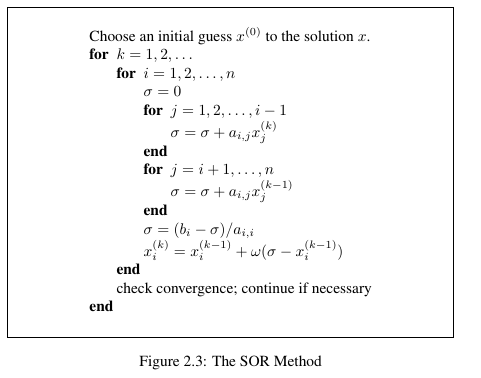

In [26]:
def solve_SOR_no_matrix( rho, guess, omega, norm_abs_tol=1e-6, maxiter=100 ):
    prev_phi = guess        
    for k in range( maxiter ):
        updated_phi = single_SOR_no_matrix_iteration( rho, prev_phi, omega ) # todo: accept next_phi
        print( "iteration", k )
        print( updated_phi )
        if is_converged( prev_phi, updated_phi, norm_abs_tol ):
            return updated_phi
        prev_phi = updated_phi
    print( "Warning: didn't converge after maxiter" )
    return updated_phi

# todo: do not use prev_phi;
# problem without prev_phi: how to check convergence?
def single_SOR_no_matrix_iteration( rho, prev_phi, omega ):
    dxdx = dx * dx
    dydy = dy * dy
    dxdxdydy = dxdx * dydy
    two_times_dxdx_plus_dydy = 2 * (dxdx + dydy)
    x_step = 2
    updated_phi = np.empty_like( prev_phi )
    for i in range(nx):
        updated_phi[i][0] = prev_phi[i][0]
        updated_phi[i][ny-1] = prev_phi[i][ny-1]
    for j in range(ny):
        updated_phi[0][j] = prev_phi[0][j]
        updated_phi[nx-1][j] = prev_phi[nx-1][j]
    # red
    for j in range(1, ny - 1):        
        if odd( j ):
            x_start = 1
            for i in range(x_start, nx - 1, x_step):
                gs = (prev_phi[i-1][j] + prev_phi[i+1][j]) * dydy
                gs = gs + (prev_phi[i][j-1] + prev_phi[i][j+1]) * dxdx
                gs = gs - rho[i][j] * dxdxdydy
                gs = gs / two_times_dxdx_plus_dydy
                updated_phi[i][j] = prev_phi[i][j] + omega * ( gs - prev_phi[i][j] )
        else:
            x_start = 2
            for i in range(x_start, nx - 1, x_step):
                gs = (prev_phi[i-1][j] + prev_phi[i+1][j]) * dydy
                gs = gs + (prev_phi[i][j-1] + prev_phi[i][j+1]) * dxdx
                gs = gs - rho[i][j] * dxdxdydy
                gs = gs / two_times_dxdx_plus_dydy
                updated_phi[i][j] = prev_phi[i][j] + omega * ( gs - prev_phi[i][j] )
    # black
    for j in range(1, ny - 1):
        if odd( j ):
            x_start = 2
            for i in range(x_start, nx - 1, x_step):
                gs = (updated_phi[i-1][j] + updated_phi[i+1][j]) * dydy
                gs = gs + (updated_phi[i][j-1] + updated_phi[i][j+1]) * dxdx
                gs = gs - rho[i][j] * dxdxdydy
                gs = gs / two_times_dxdx_plus_dydy
                updated_phi[i][j] = prev_phi[i][j] + omega * ( gs - prev_phi[i][j] )
        else:
            x_start = 1
            for i in range(x_start, nx - 1, x_step):
                gs = (updated_phi[i-1][j] + updated_phi[i+1][j]) * dydy
                gs = gs + (updated_phi[i][j-1] + updated_phi[i][j+1]) * dxdx
                gs = gs - rho[i][j] * dxdxdydy
                gs = gs / two_times_dxdx_plus_dydy
                updated_phi[i][j] = prev_phi[i][j] + omega * ( gs - prev_phi[i][j] )
    return updated_phi


In [27]:
nx = 8
ny = 8
dx = 0.1
dy = 0.3
x0 = 0
y0 = 0

exact_sol = np.empty( [nx, ny] )
approx_sol = np.empty_like( exact_sol )
rhs = np.empty_like( exact_sol )

exact_sol = set_exact_solution( exact_sol )
rhs = set_rhs( rhs )
approx_sol = set_boundary_cond_in_approx_sol( approx_sol )

print( exact_sol )
print( approx_sol )


[[ 0.     0.027  0.216  0.729  1.728  3.375  5.832  9.261]
 [ 0.01   0.037  0.226  0.739  1.738  3.385  5.842  9.271]
 [ 0.04   0.067  0.256  0.769  1.768  3.415  5.872  9.301]
 [ 0.09   0.117  0.306  0.819  1.818  3.465  5.922  9.351]
 [ 0.16   0.187  0.376  0.889  1.888  3.535  5.992  9.421]
 [ 0.25   0.277  0.466  0.979  1.978  3.625  6.082  9.511]
 [ 0.36   0.387  0.576  1.089  2.088  3.735  6.192  9.621]
 [ 0.49   0.517  0.706  1.219  2.218  3.865  6.322  9.751]]
[[ 0.     0.027  0.216  0.729  1.728  3.375  5.832  9.261]
 [ 0.01   0.     0.     0.     0.     0.     0.     9.271]
 [ 0.04   0.     0.     0.     0.     0.     0.     9.301]
 [ 0.09   0.     0.     0.     0.     0.     0.     9.351]
 [ 0.16   0.     0.     0.     0.     0.     0.     9.421]
 [ 0.25   0.     0.     0.     0.     0.     0.     9.511]
 [ 0.36   0.     0.     0.     0.     0.     0.     9.621]
 [ 0.49   0.517  0.706  1.219  2.218  3.865  6.322  9.751]]


In [28]:
guess = approx_sol
abs_tol = np.max([dx**2, dy**2]) / 10
print( guess )
omega = 2 - np.max( [dx, dy] ) if 2 - np.max( [dx, dy] ) > 0 and 2 - np.max( [dx, dy] ) < 2  else 1.5
approx_sol = solve_SOR_no_matrix( rhs, guess, omega, norm_abs_tol=abs_tol, maxiter=100 )

[[ 0.     0.027  0.216  0.729  1.728  3.375  5.832  9.261]
 [ 0.01   0.     0.     0.     0.     0.     0.     9.271]
 [ 0.04   0.     0.     0.     0.     0.     0.     9.301]
 [ 0.09   0.     0.     0.     0.     0.     0.     9.351]
 [ 0.16   0.     0.     0.     0.     0.     0.     9.421]
 [ 0.25   0.     0.     0.     0.     0.     0.     9.511]
 [ 0.36   0.     0.     0.     0.     0.     0.     9.621]
 [ 0.49   0.517  0.706  1.219  2.218  3.865  6.322  9.751]]
iteration 0
[[  0.00000000e+00   2.70000000e-02   2.16000000e-01   7.29000000e-01
    1.72800000e+00   3.37500000e+00   5.83200000e+00   9.26100000e+00]
 [  1.00000000e-02  -7.56500000e-03   1.31575750e-01   5.01075000e-01
    1.45259730e+00   2.49772500e+00   5.89379035e+00   9.27100000e+00]
 [  4.00000000e-02  -5.14849250e-02  -4.28400000e-02   2.73782025e-01
   -7.03800000e-02   1.81512910e+00   6.92665000e-01   9.30100000e+00]
 [  9.00000000e-02  -2.14200000e-02  -1.15017750e-01  -5.66100000e-02
   -1.90026000e-01  -8

In [29]:
compare_appr_and_exact( exact_sol, approx_sol )

0 0 | 0.0 0.0 | 0.0 nan
0 1 | 0.027 0.027 | 0.0 0.0
0 2 | 0.216 0.216 | 0.0 0.0
0 3 | 0.729 0.729 | 0.0 0.0
0 4 | 1.728 1.728 | 0.0 0.0
0 5 | 3.375 3.375 | 0.0 0.0
0 6 | 5.832 5.832 | 0.0 0.0
0 7 | 9.261 9.261 | 0.0 0.0
1 0 | 0.01 0.01 | 0.0 0.0
1 1 | 0.037 0.0369929438482 | 7.05615180164e-06 0.00019070680545
1 2 | 0.226 0.225997140172 | 2.85982824588e-06 1.26541072827e-05
1 3 | 0.739 0.739000156326 | -1.56326003142e-07 -2.11537216701e-07
1 4 | 1.738 1.73800873499 | -8.73499231346e-06 -5.02588740706e-06
1 5 | 3.385 3.38500213143 | -2.13143303052e-06 -6.29670023786e-07
1 6 | 5.842 5.84200275286 | -2.75285716622e-06 -4.71218275628e-07
1 7 | 9.271 9.271 | 0.0 0.0
2 0 | 0.04 0.04 | 0.0 0.0
2 1 | 0.067 0.0669995189498 | 4.81050208778e-07 7.17985386236e-06
2 2 | 0.256 0.256002871178 | -2.87117759357e-06 -1.12155374749e-05
2 3 | 0.769 0.769002459909 | -2.45990898773e-06 -3.19884133645e-06
2 4 | 1.768 1.76801737049 | -1.73704928352e-05 -9.82493938644e-06
2 5 | 3.415 3.41501167744 | -1.16774395

/home/noway/progs/python/jupyter_venv/local/lib/python3.4/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in double_scalars
  


# In 3d case

Poisson's equation:

$\Delta \phi = \rho$

In 3d in Cartesian coords:

$\dfrac{ \partial^2 \phi }{ \partial x^2 } + 
 \dfrac{ \partial^2 \phi }{ \partial y^2 } +
 \dfrac{ \partial^2 \phi }{ \partial z^2 }= \rho$

Discretizing the equation using finite difference method
with [central difference](https://en.wikipedia.org/wiki/Finite_difference) for 2nd order derivative:

$\dfrac{ \phi_{i-1,j,k} - 2 \phi_{i,j,k} + \phi_{i+1,j,k} }{ \Delta x^2 } + 
 \dfrac{ \phi_{i,j-1,k} - 2 \phi_{i,j,k} + \phi_{i,j+1,k} }{ \Delta y^2 } +
 \dfrac{ \phi_{i,j,k-1} - 2 \phi_{i,j,k} + \phi_{i,j,k+1} }{ \Delta z^2 } = \rho$
 
Simple approach:

$\Delta y^2 \Delta z^2 ( \phi_{i-1,j,k} - 2 \phi_{i,j,k} + \phi_{i+1,j,k} ) + 
 \Delta x^2 \Delta z^2 ( \phi_{i,j-1,k} - 2 \phi_{i,j,k} + \phi_{i,j+1,k} ) + 
 \Delta x^2 \Delta y^2 ( \phi_{i,j,k-1} - 2 \phi_{i,j,k} + \phi_{i,j,k+1} ) = \rho \Delta x^2 \Delta y^2 \Delta z^2$


$ \phi_{i,j,k} = 
\dfrac{ \Delta y^2 \Delta z^2 ( \phi_{i-1,j,k} + \phi_{i+1,j,k} ) + 
        \Delta x^2 \Delta z^2 ( \phi_{i,j-1,k} + \phi_{i,j+1,k} ) +
        \Delta x^2 \Delta y^2 ( \phi_{i,j,k-1} + \phi_{i,j,k+1} ) - \rho \Delta x^2 \Delta y^2 \Delta z^2 }
        {2 (\Delta x^2 \Delta y^2 + \Delta x^2 \Delta z^2 + \Delta y^2 \Delta z^2) }$

This can be solved iteratively:

$ \phi_{i,j,k}^{next} = 
\dfrac{ \Delta y^2 \Delta z^2 ( \phi_{i-1,j,k}^{prev} + \phi_{i+1,j,k}^{prev} ) + 
        \Delta x^2 \Delta z^2 ( \phi_{i,j-1,k}^{prev} + \phi_{i,j+1,k}^{prev} ) +
        \Delta x^2 \Delta y^2 ( \phi_{i,j,k-1}^{prev} + \phi_{i,j,k+1}^{prev} ) - \rho \Delta x^2 \Delta y^2 \Delta z^2 }
        {2 (\Delta x^2 \Delta y^2 + \Delta x^2 \Delta z^2 + \Delta y^2 \Delta z^2) }$
